In [1]:
pip install keras

In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Input, Dense
from matplotlib import pyplot as pyplot

import os
import numpy as np
from numpy.fft import rfft, irfft
import scipy.signal as sig

from functools import partial
rfft = partial(rfft, norm='ortho')
irfft = partial(irfft, norm='ortho')

In [3]:
def center(data):
    """Shift data from the start to the center of a time series"""
    return np.roll(data, len(data)//2)

def downsample_invasd(invasd, tlen=1024):
    """Reduce frequency resolution of the inverse ASD to a given number of time samples"""
    tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))
    tmp[0] = 0.
    return tmp

def to_fd(data):
    """Convert to frequency domain with t=0 in center"""
    return rfft(np.roll(data, -len(data)//2))

def extract_glitch(npz, halfwidth=512):
    """Returns 1/4 second inverse ASD and 2 sec of whitened glich, @8192Hz"""
    invasd = ((4096.*npz['psd'])**-0.5)[:4097]
    invasd[:10] = 0.
    filt = np.zeros(4*8192)
    filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
    fdfilt = np.abs(rfft(filt)) # This is a one-second resolution invasd

    whts = irfft(fdfilt*rfft(npz['data']))
    invasd_ds = downsample_invasd(invasd)

    return invasd_ds, whts[len(whts)//2 - halfwidth:len(whts)//2 + halfwidth],  whts

def snr(snip):
    tmp = np.zeros(4*8192)
    tmp[:len(snip.glitch)] = snip.glitch.copy()
    gt = TimeSeries(np.roll(tmp,-len(snip.glitch)//2), delta_t=1/8192)
    dt = TimeSeries(snip.whts_long, delta_t=1/8192)
    dt[:4096]=0.;dt[len(dt)-4096:]=0.;
    snrts = matched_filter(gt, dt, psd=FrequencySeries([1./4096]*(1+4*4906), delta_f=1/4.), low_frequency_cutoff=15)

    return np.abs(snrts[16384-2048:16384+2048]).max()

def measure(inf_data, snip):
    itrace = inf_data['mean']
    inf = {key: float(itrace[key])
            for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
    strace = inf_data['sd']
    inf |= {key+'_sd': float(strace[key])
            for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
    cpamp = inf['amp_r']+1.j*inf['amp_i']
    inf['amp'] = np.abs(cpamp)
    inf['phase'] = np.angle(cpamp)
    inf['time'] = inf['time']
    snip.set_infer(inf)
    inf['snr'] = snr(snip)
    inf['power'] = np.sum((snip.whts[256:768])**2)/512
    inf['residual'] = np.sum(((snip.whts-snip.glitch)[256:768])**2)/512
    inf['peak_frequency'] = float(freqs[(snip.invasd*np.abs(snip.fglitch)).argmax()])
    return inf, snip

class Snippet:
    """A class to load and whiten data, """
    def __init__(self, filename):
        #self.ifo, self.key, self.num = ifo, key, num
        npz = np.load(filename)
        self.invasd, self.whts, self.whts_long = extract_glitch(npz)
    def set_infer(self, inf):
        self.inf = inf


    def plot(self):
        myfreqs = np.linspace(0,4096,513)

        import matplotlib.pyplot as plt
        fig1 = plt.figure()
        #plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.loglog(myfreqs, np.abs(rfft(self.whts)), c='k', lw=1)
        plt.ylim(1e-2,1e2)

        fig2 = plt.figure()
        #plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.plot(self.whts, c='k', lw=1)


        return fig1, fig2

class SnippetNormed:
    """A class to load and whiten data, """
    def __init__(self, ifo, key, num):
        self.ifo, self.key, self.num = ifo, key, num
        npz = np.load(f"{datadir}/{ifo}-{key}-{num:04d}.npz")
        self.invasd, self.whts, self.whts_long = extract_glitch(npz)
    def set_infer(self, inf):
        self.inf = inf
    @property
    def fglitch(self):
        """Glitch centered at the start index"""
        return fglitch_normed(self.invasd, **self.inf)
    @property
    def glitch(self):
        """Whitened glitch time series"""
        ftmp = fglitch_normed(self.invasd, **self.inf)
        tmp = irfft(ftmp)
        return center(tmp)

    def plot(self):
        myfreqs = np.linspace(0,4096,513)

        import matplotlib.pyplot as plt
        fig1 = plt.figure()
        plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.loglog(myfreqs, np.abs(rfft(self.whts)), c='k', lw=1)
        plt.loglog(myfreqs, np.abs(rfft(self.glitch)), c='b', lw=1)
        plt.loglog(myfreqs, np.abs(rfft(self.whts - self.glitch)), c='orange')
        plt.ylim(1e-2,1e2)

        fig2 = plt.figure()
        plt.title(f"{self.ifo} {self.key} {self.num}")
        plt.plot(self.whts, c='k', lw=1)
        plt.plot(self.whts - self.glitch, c='orange', ls=':')

        return fig1, fig2


### LOAD THE DATA


In [4]:

# Loaded data from NPZ file
#data = np.load('/content/drive/MyDrive/Colab Notebooks/Project Notebooks/L1-glitches-clean.zip')
from numpy import load

data = load('/content/drive/MyDrive/Colab Notebooks/Project Notebooks/L1-glitches-clean.zip')


# Normalize the data
#glitch_data = glitch_data / np.max(glitch_data)


### QUICK LOOK AT THE DATA

In [5]:
lst = data.files
for item in lst:
    print(item)
    print(data[item])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
#pyplot.plot(data)
#pyplot.show()

In [37]:
import zipfile
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from glob import glob

# Path to your zip folder containing the .npz files
file_path = '/content/drive/MyDrive/Colab Notebooks/Project Notebooks/data/'

filelist = sorted(glob(file_path + '*koi*.npz'))

# Temporary directory to extract files
temp_dir = 'temp_dir'

# Counter for error processing files
error_count = 0

all_data = []
for npz_file in filelist:
  data = Snippet(npz_file)
  all_data.append(data.whts)

all_data = np.array(all_data)


scaler = MinMaxScaler()
#normalized_array_data = scaler.fit_transform(all_data.reshape(-1, 1)).flatten()

#all_data = all_data / np.max(np.abs(all_data))


# Normalize and save the mean and std we get,
# for normalizing test data.


#TRAINING THE AUTOENCODER#
# Split the dataset into training and testing sets, with 20% of the data designated for testing.
# 'all_data' is the dataset to be split, 'test_size=0.2' specifies the proportion of the dataset to include in the test split,
# and 'random_state=42' ensures reproducibility by seeding the random number generator.
X_train, X_test = train_test_split(all_data, test_size=0.2, random_state=43)

# Generate random labels for the training data, choosing between True and False.
# The number of labels generated is equal to the number of samples in the training set.
train_labels = np.random.choice([True, False], size=X_train.shape[0])

# Generate random labels for the testing data, choosing between True and False.
# The number of labels generated is equal to the number of samples in the testing set.
test_labels = np.random.choice([True, False], size=X_test.shape[0])

# Select the subset of normal data from the training set based on the randomly generated labels.
# This subset contains samples labeled as True.
normal_train_data = X_train[train_labels]

# Select the subset of normal data from the testing set based on the randomly generated labels.
# This subset contains samples labeled as True.
normal_test_data = X_test[test_labels]

# Select the subset of anomalous data from the training set based on the inverse of the randomly generated labels.
# This subset contains samples labeled as False.
anomalous_train_data = X_train[~train_labels]

# Select the subset of anomalous data from the testing set based on the inverse of the randomly generated labels.
# This subset contains samples labeled as False.
anomalous_test_data = X_test[~test_labels]





<ipython-input-3-ce0a007c1768>:17: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]
<ipython-input-3-ce0a007c1768>:20: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  filt[:8192] = sig.hann(8192)*np.roll(irfft(invasd), 4096)
<ipython-input-3-ce0a007c1768>:7: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  tmp = np.abs(rfft(sig.hann(tlen)*np.roll(irfft(invasd), tlen//2)[:tlen]))


In [8]:
all_data.shape #training data

(100, 1024)

In [9]:
plt.plot(all_data.whts)

AttributeError: 'numpy.ndarray' object has no attribute 'whts'

In [ ]:
training_mean = X_train.mean()
training_std = X_train.std()
df_training_value = (X_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

In [38]:


# Build an autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 8  # Example encoding dimension


encoder = Sequential([
    Dense(500, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(encoding_dim, activation='relu')
])


decoder = Sequential([
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(input_dim)
])


autoencoder = Sequential([
    encoder,
    decoder
])

opt = keras.optimizers.AdamW( weight_decay=0.01)
autoencoder.compile(optimizer=opt, loss='mse',)
autoencoder.summary()

# Train the autoencoder model
history= autoencoder.fit(X_train,
                X_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


# Additional step: Further train the model
#history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Evaluate the trained model
loss = autoencoder.evaluate(X_test, X_test)
#print(f'Test loss for {key}: {loss}')


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 8)                 694708    
                                                                 
 sequential_22 (Sequential)  (None, 1024)              695724    
                                                                 
Total params: 1390432 (5.30 MB)
Trainable params: 1390432 (5.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
3/3 [==============================] - 2s 125ms/step - loss: 214.3737 - val_loss: 275.8428
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 209.2032 - val_loss: 275.8395
Epoch 3/200
3/3 [==============================] - 0s 34ms/step - loss: 206.7516 - val_loss: 275.8351
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 206.6404 - val_loss: 275.8216
Ep

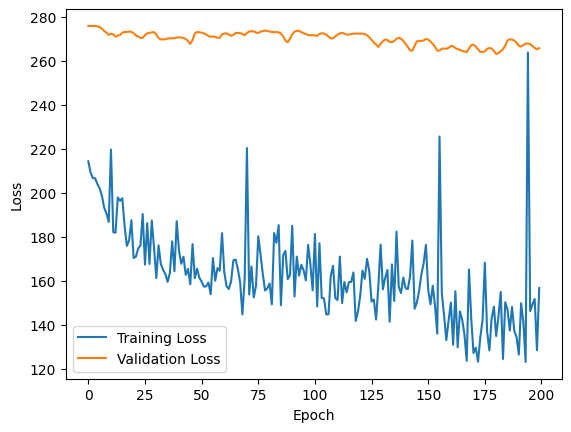

In [39]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

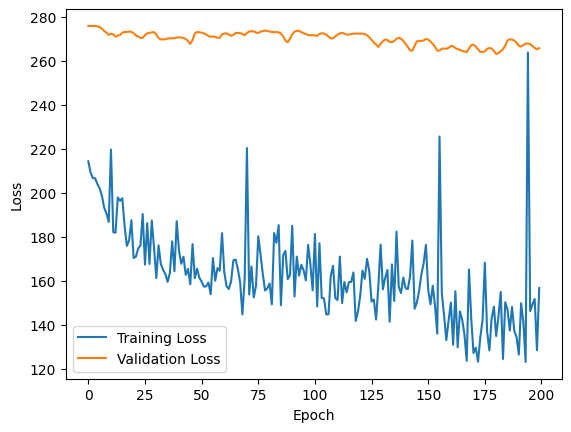

In [40]:
plt.plot(history.history["loss"], label="Training Loss")  # for weight decay version
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
test = autoencoder(X_test)

In [ ]:
# Get train MAE loss.
x_train_pred = autoencoder.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

# Checking how the first sequence is learnt
plt.plot(X_train[0], color='k', label='Original')  # original
#plt.plot(x_train_pred[0], label='Model')
plt.xlabel('Time [ms]')
plt.ylabel('Whitened Amplitude')
plt.legend(loc='upper right')
plt.show()

threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [12]:
plt.plot(x_train_pred[0], label='Model')
plt.legend(loc='upper right')

NameError: name 'x_train_pred' is not defined

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

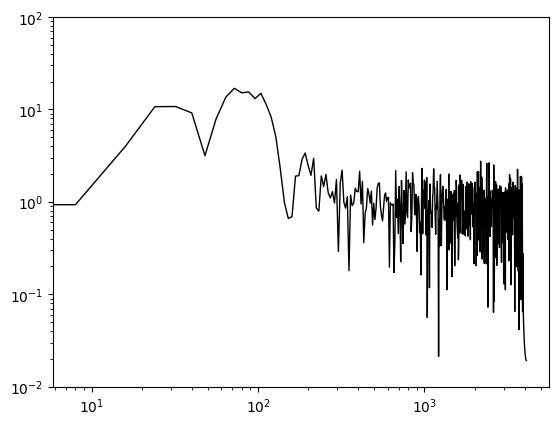

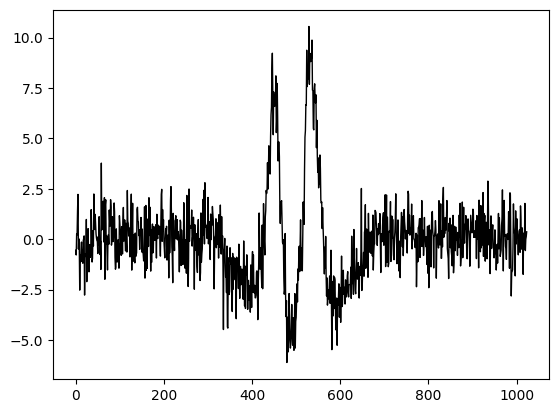

In [41]:
data.plot()

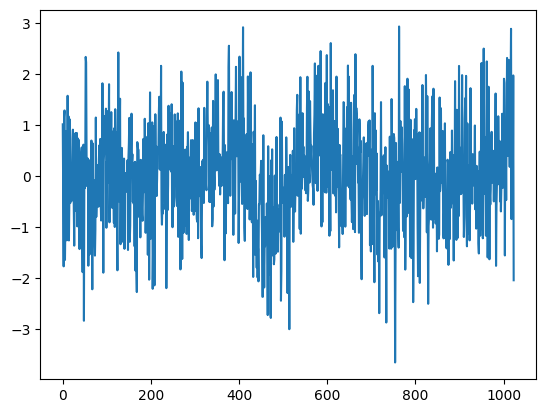

In [17]:
plt.plot(data.whts)

(array([ 1., 10., 18., 27., 57., 49., 49., 27.,  8.,  4.]),
 array([-2.83083752, -2.30568239, -1.78052727, -1.25537214, -0.73021702,
        -0.2050619 ,  0.32009323,  0.84524835,  1.37040348,  1.8955586 ,
         2.42071372]),
 <BarContainer object of 10 artists>)

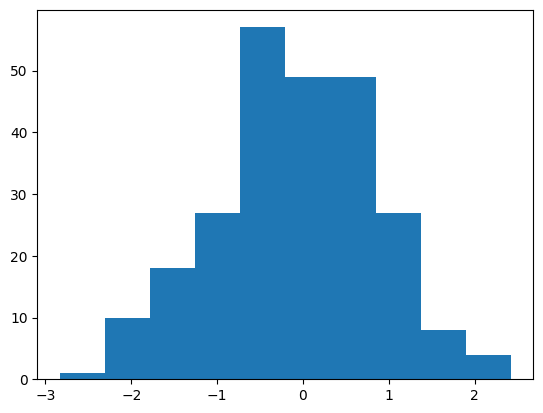

In [18]:
plt.hist(data.whts[0:250])

In [25]:
np.var(X_train[:,:256])

0.9889477110840138

In [15]:
plt.plot(x_train_pred[0])

NameError: name 'x_train_pred' is not defined

In [ ]:
data.plot()

NameError: name 'test' is not defined

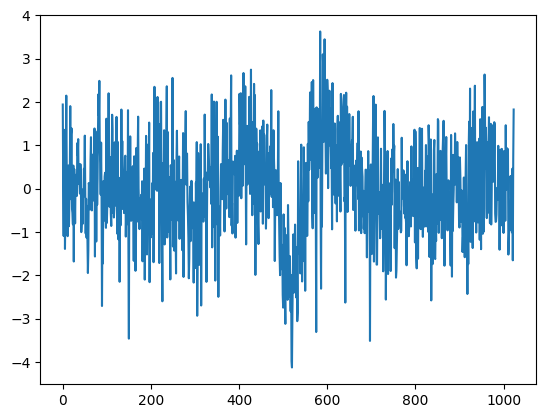

In [13]:
plt.plot(X_test[8], label='Original')
plt.plot(test[8], label='Model')
plt.xlabel("Time [ms]")
plt.ylabel("Whitened Amplitude")
plt.legend(loc='upper right')

In [16]:
plt.plot(test[8])

NameError: name 'test' is not defined

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = X_train.mean()
training_std = X_train.std()
df_training_value = (X_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

In [ ]:
# Get test MAE loss.
x_test_pred = autoencoder.predict(X_test)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.plot(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
data = Snippet('/content/drive/MyDrive/Colab Notebooks/Project Notebooks/data/L1-blip-0000.npz')



In [ ]:
plt.plot(data.whts)

In [ ]:
data.whts.shape

In [ ]:
 #data.keys()
data['data']

In [ ]:

irfft = partial(irfft, norm='ortho')